In [1]:
# Load results
import os
import pandas as pd

results = pd.DataFrame()
results_path = "./results/extraction/paraphrase_chat/"
result_file_list = os.listdir(results_path)
for filename in result_file_list:
    df = pd.read_csv(results_path + filename, names = ["filename", "turn", "full_summary", "omitted_summary", "similarity"])
    results = pd.concat([results, df])


In [2]:
# Cast dtype
results = results.astype({"similarity": float, "turn": int})

results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 952 entries, 0 to 8
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   filename         952 non-null    object 
 1   turn             952 non-null    int64  
 2   full_summary     952 non-null    object 
 3   omitted_summary  952 non-null    object 
 4   similarity       952 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 44.6+ KB


In [3]:
# Remove duplicates
results = results.drop_duplicates(subset=["filename", "turn"], keep="last")

#print(results)

Text(0, 0.5, 'Frequency')

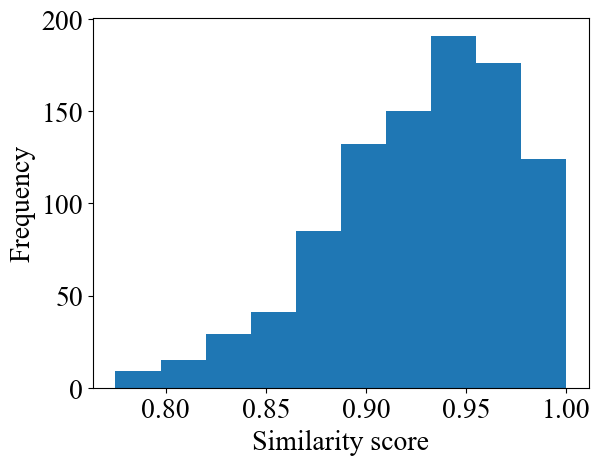

In [4]:
# Show histogram
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"   # 使用するフォント
plt.rcParams["font.size"] = 20                 # 文字の大きさ

hist = plt.hist(results["similarity"])
plt.xlabel("Similarity score")
plt.ylabel("Frequency")

In [4]:
# Sort by similarity
results = results.sort_values("similarity")
#results = results.reset_index()

#print(results)

In [6]:
# Show top and bottom
def show_row(row):
    with open("./dat/" + row.filename) as f:
        dialogue = [l.rstrip() for l in f.readlines()]
    
    full_dialogue = "\n".join(dialogue[:row.turn + 1])
    print("-----------------")
    print("filename")
    print(row.filename)
    print("full dialogue")
    print(full_dialogue)
    print("full summary")
    print(row.full_summary)
    print("omitted summary")
    print(row.omitted_summary)
    print("similarity") 
    print(row.similarity)
    return

NUM_EXAMPLES = 5
for row in results.head(NUM_EXAMPLES).itertuples():
    show_row(row)

for row in results.tail(NUM_EXAMPLES).itertuples():
    show_row(row)



-----------------
filename
PP55.txt
full dialogue
A: ねえ、ちょっと話、聞いてくれる？
B: どうしたの？
A: 彼氏がさあ、わたしの関西弁をすごく嫌がるんだよね。オバチャンみたいっていうの。
B: わたしは近畿に地方に住んでるから全然そんなこと思わないけどそれちょっとひどいね
A: ひどいよねー！でもさ、高卒で、しかも気分屋のわたしと付き合ってくれる男性なんて、そうそういないしなあ。
B: 関係ないと思うけどな。わたしは大卒だけど同級生は高卒の子と結婚したよ。とりあえず元気出して！
A: ありがとう！あ！そういえば、もっと酷いことを言われたの思い出しちゃった！
B: さらに！？
A: デートで、茶色の髪の毛に合わせて、ヒョウ柄のタンクトップ着ていったら、おまえは女豹かってツッコまれた。
B: うーん、、それはフォローできないかなー。でもツッコミができる彼は悪くないんじゃない？
A: そう？そうかな？わたしたちカップルって、これからもうまくやっていけると思う？
B: 意外にお似合いなのかもね！
full summary
あなたたちはお互いをよく理解し、お互いを尊重しているから、きっとうまくやっていけると思うよ。
omitted summary
茶色の髪の毛に合わせたヒョウ柄のタンクトップが似合っているかもね！
similarity
0.7748776384123496
-----------------
filename
PP59.txt
full dialogue
A: こんにちは。最近はどんなことをされてますか？
B: 最近は新卒で入社した今の会社で働き詰めです。おかげでいつも寝不足ですよ。あなたは？
A: 勤め人は大変だね。わたしは、何度も転職した結果、自由気ままなフリーランスが性に合ってるってことが分かったよ。
B: フリーランスかあ。かっこいいなあ。わたしは我慢強いのだけが取り柄だから今の会社でもう少し頑張ろうと思ってるよ。
A: えらいなあ。わたしの場合は、敵を作るタイプなんだよねー。原因は多分、わたしにあるんだろうけど。。。
B: そんなにきつい性格だったかな？
A: んー、性格っていうか、リーダーシップを取るのが、自分では得意だと思ってるんだけど、大学中退のくせに偉そうにしてって感じる人も多いみたい

0. A: こんにちは！元気にしていましたか？
1. B: はい！自衛官ですから！元気だけは自信があります。あなたは元気にしてましたか？
2. A: はい！私も吹奏楽部員なので肺活量には自信があります！自衛官って体を鍛えたり、やっぱり大変ですか？
3. B: 吹奏楽部いいですね〜！自衛官は大変なこともありますが、ガッツで乗り切ってますよ！元応援団なもので！
4. A: そうだったんですね！どうりでお声が通ると思いました。わたしもいつかメイクアップアーティストになりたいんですが、あなたのようにいきいきと働けたらいいなと思います。
5. B: メイクアップアーティストですか！あなたならきっとなれる！
6. A: あなたの応援があれば叶う気がします！いつか夢が叶ったら、世界中を飛び回ってみたいんです！あなたにも今、叶えたいこととかありますか？
7. B: そうですね。今はとにかく目の前の仕事を責任持ってこなしたいですね。
8. A: 責任を持ってお仕事をするって、大切なことですよね。尊敬します！まだ10代ですが、将来はあなたのように責任感のある大人になりたいです！
9. B: 10代ですか！今のうちにたくさんの経験をして素敵な大人になってくださいね！
10. A: はい！たくさんいる友達にもあなたとの今日のことを話して、皆で夢に向かって頑張ろうと思います！
11. B: 応援します！フレーフレー！


<Axes: xlabel='turn'>

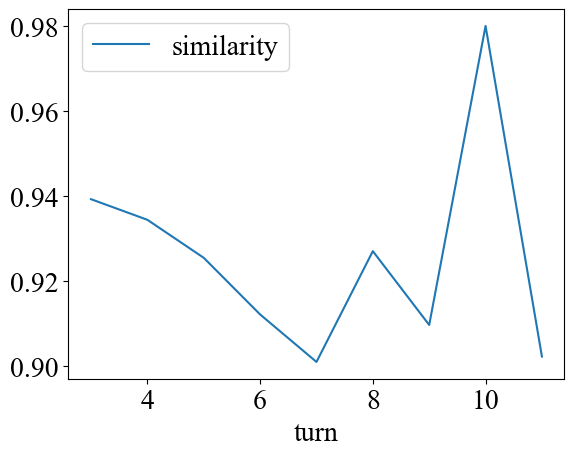

In [7]:
# Show graph
import matplotlib.pyplot as plt
DIALOGUE_NUMBER = 98

result = results.query(f"filename == 'PP{DIALOGUE_NUMBER}.txt'")
result = result.sort_values("turn", ascending=True)

with open(f"./dat/PP{DIALOGUE_NUMBER}.txt") as f:
    dialogue = [l.rstrip() for l in f.readlines()]

dialogue_with_line_number = []
for idx, l in enumerate(dialogue):
    dialogue_with_line_number.append(str(idx) + ". " + l)

print("\n".join(dialogue_with_line_number))
result.plot(x="turn", y="similarity")

In [5]:
# Count number of sentences similarity < 0.9
threshold = 0.85
under_threshold = results["similarity"] < threshold
n_under_threshold = under_threshold.sum()
print(n_under_threshold)
results_under_threshold = results[under_threshold]
bottom_results = results_under_threshold.reset_index()

65


In [6]:
# Collect top samples with the same number as under threshold
top_results = results.tail(n_under_threshold)
top_results = top_results.reset_index()
top_threshold = top_results["similarity"].min()
print(top_threshold)

0.9897329897748932


In [7]:
# Create samples for survey
n_sample = 5
sample_size_low = 10
sample_size_high = 0

samples = []
for i in range(n_sample):
    sample = pd.DataFrame(columns=bottom_results.columns)
    n_rows = 0
    while n_rows < sample_size_low:
        low_candidate = bottom_results.sample(n=1)
        low_candidate["condition"] = "low"
        sample = pd.concat([sample, low_candidate])
        sample = sample.drop_duplicates(keep="first", subset="filename")
        n_rows = len(sample)
    bottom_results.drop(sample.head(sample_size_low).index, inplace=True)

    while n_rows < sample_size_low + sample_size_high:
        high_candidate = top_results.sample(n=1)
        high_candidate["condition"] = "high"
        sample = pd.concat([sample, high_candidate])
        sample = sample.drop_duplicates(keep="first", subset="filename")
        n_rows = len(sample)
    top_results.drop(sample.tail(sample_size_high).index, inplace=True)

    # Check filename
    print(sample["filename"])    
    samples.append(sample)


12    PP56.txt
60    PP42.txt
5     PP29.txt
2      PP2.txt
30    PP13.txt
54    PP99.txt
17    PP51.txt
21    PP40.txt
52     PP9.txt
14    PP23.txt
Name: filename, dtype: object
43    PP33.txt
22    PP60.txt
61    PP58.txt
32    PP49.txt
63    PP44.txt
31    PP34.txt
49    PP55.txt
29    PP80.txt
9     PP45.txt
39    PP73.txt
Name: filename, dtype: object
13    PP59.txt
27    PP47.txt
8     PP55.txt
51     PP9.txt
19    PP96.txt
6     PP29.txt
20    PP60.txt
59    PP40.txt
28    PP65.txt
42    PP94.txt
Name: filename, dtype: object
53    PP90.txt
33     PP5.txt
15    PP71.txt
47    PP11.txt
57    PP83.txt
46    PP27.txt
16    PP31.txt
37    PP22.txt
40     PP7.txt
62     PP6.txt
Name: filename, dtype: object
50    PP78.txt
36    PP70.txt
7     PP61.txt
25    PP38.txt
35    PP32.txt
11    PP10.txt
58    PP90.txt
24     PP6.txt
4     PP52.txt
64    PP94.txt
Name: filename, dtype: object


In [10]:
# Create CSV for assistance
import csv

SPEAKERS = ["A: ", "B: "]

for sample_number, sample in enumerate(samples):
    shuffled_sample = sample.sample(frac=1)
    sample_CSV = pd.DataFrame({
        "sample_number": [],
        "dialogue_number": [],
        "full_dialogue": [],
        "assist_utterance": []
        })
    sample_CSV = sample_CSV.astype({
        "sample_number": int,
        "dialogue_number": int,
        "full_dialogue": str,
        "assist_utterance": str
    })
    for dialogue_number, row in enumerate(shuffled_sample.itertuples()):
        with open("./dat/" + row.filename) as f:
            dialogue = [l.rstrip() for l in f.readlines()]
        
        full_dialogue = "\n".join(dialogue[:row.turn + 1])
        sample_CSV = pd.concat([sample_CSV, pd.DataFrame({
            "sample_number": [int(sample_number)],
            "dialogue_number": [int(dialogue_number)],
            "full_dialogue": [full_dialogue],
            "assist_utterance": [""]
        })])

    csv_filename = "./forms/assist{:03}.csv".format(sample_number)
    sample_CSV.to_csv(csv_filename)



In [ ]:
# Create CSV
import csv

SPEAKERS = ["A: ", "B: "]

for idx, sample in enumerate(samples):
    shuffled_sample = sample.sample(frac=1)
    sample_CSV = pd.DataFrame({
        "full_dialogue": [],
        "omitted_dialogue": [],
        "core_sentence": [],
        "condition": []
        })
    for row in shuffled_sample.itertuples():
        with open("./dat/" + row.filename) as f:
            dialogue = [l.rstrip() for l in f.readlines()]
        
        full_dialogue = "\n\n".join(dialogue[:row.turn + 1])
        omitted_dialogue = "\n\n".join(dialogue[:row.turn - 2] + dialogue[row.turn:row.turn + 1])
        core_sentence = dialogue[row.turn]
        for speaker in SPEAKERS:
            core_sentence = core_sentence.removeprefix(speaker)
        condition = row.condition
        sample_CSV = pd.concat([sample_CSV, pd.DataFrame({
        "full_dialogue": [full_dialogue],
        "omitted_dialogue": [omitted_dialogue],
        "core_sentence": [core_sentence],
        "condition": [condition]
        })])

    csv_filename = "./forms/sample{:03}.csv".format(idx + 1)
    sample_CSV.to_csv(csv_filename)



In [1]:
# Create tex
import pandas as pd
n_samples = 10

for survey_idx in range(n_samples):

    SURVEY_NUMBER = survey_idx + 1
    csv_filename = "./forms/sample{:03}.csv".format(SURVEY_NUMBER)
    sample_CSV = pd.read_csv(csv_filename)

    head_path = "./tex/head.tex"
    with open(head_path) as head_file:
        head_tex = head_file.read()
    tail_path = "./tex/tail.tex"
    with open(tail_path) as tail_file:
        tail_tex = tail_file.read()

    for idx, row in enumerate(sample_CSV.itertuples()):
        underlined_core_sentence = "\\ul{" + row.core_sentence + "}"
        underlined_full = row.full_dialogue.replace(row.core_sentence, underlined_core_sentence)
        full_path = "./forms/" + str(SURVEY_NUMBER).zfill(3) + "_" + str(idx).zfill(3) + "full.tex"
        with open(full_path, mode='w') as output_file:
            output_file.write(head_tex)
            output_file.write(underlined_full)
            output_file.write(tail_tex)

        full_name = "forms/" + str(SURVEY_NUMBER).zfill(3) + "_" + str(idx).zfill(3) + "full"
        !ptex2pdf -l {full_name} -output-directory "forms/"


        underlined_omitted = row.omitted_dialogue.replace(row.core_sentence, underlined_core_sentence)
        omitted_path = "./forms/" + str(SURVEY_NUMBER).zfill(3) + "_" + str(idx).zfill(3) + "omitted.tex"
        with open(omitted_path, mode='w') as output_file:
            output_file.write(head_tex)
            output_file.write(underlined_omitted)
            output_file.write(tail_tex)

        omitted_name = "forms/" + str(SURVEY_NUMBER).zfill(3) + "_" + str(idx).zfill(3) + "omitted"
        !ptex2pdf -l {omitted_name} -output-directory "forms/"


This is ptex2pdf[.lua] version 20200520.0.
Processing forms/010_000full
This is e-pTeX, Version 3.141592653-p4.1.0-230214-2.6 (utf8.euc) (TeX Live 2023) (preloaded format=platex)
 restricted \write18 enabled.
entering extended mode
(./forms/010_000full.tex(guessed encoding #3: UTF-8 = utf8)
pLaTeX2e <2023-02-14>+1 (based on LaTeX2e <2022-11-01> patch level 1)
L3 programming layer <2023-04-20>
(/usr/local/texlive/2023/texmf-dist/tex/latex/amscls/amsart.cls(guessed encoding #5: ASCII = utf8)
Document Class: amsart 2020/05/29 v2.20.6
(/usr/local/texlive/2023/texmf-dist/tex/latex/amsmath/amsmath.sty(guessed encoding #6: ASCII = utf8)
For additional information on amsmath, use the `?' option.
(/usr/local/texlive/2023/texmf-dist/tex/latex/amsmath/amstext.sty(guessed encoding #7: ASCII = utf8)
(/usr/local/texlive/2023/texmf-dist/tex/latex/amsmath/amsgen.sty(guessed encoding #8: ASCII = utf8)))
(/usr/local/texlive/2023/texmf-dist/tex/latex/amsmath/amsbsy.sty(guessed encoding #7: ASCII = utf8))

In [5]:
# Load importance data
import os
import pandas as pd

importance_data = pd.DataFrame()
importance_path = "./results/extraction/important_chat/"
importance_file_list = os.listdir(importance_path)
for filename in importance_file_list:
    df = pd.read_csv(importance_path + filename, names = ["filename", "first", "second"])
    importance_data = pd.concat([importance_data, df])

# Cast dtype
importance_data = importance_data.astype({"first": int, "second": int})

# Remove duplicates
importance_data = importance_data.drop_duplicates(subset=["filename"], keep="last")

importance_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99 entries, 0 to 0
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  99 non-null     object
 1   first     99 non-null     int64 
 2   second    99 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 3.1+ KB


In [6]:
# Combine similarity and importance
combined_data = pd.DataFrame(
    columns=["filename", "turn", "utterance", "low_similarity", "important"]
)

n_dialogue = 100
threshold = 0.85

for idx_dialogue in range(1, n_dialogue + 1):
    filename = "PP" + str(idx_dialogue) + ".txt"
    with open("./dat/" + filename) as f:
        dialogue = [l.rstrip() for l in f.readlines()]

    importance_row = importance_data.query(
        "filename == @filename"
    )

    for idx_utterance, utterance in enumerate(dialogue):
        summary_row = results.query(
            "filename == @filename and (turn == @idx_utterance + 1 or turn == @idx_utterance + 2)"
        )
        if len(summary_row.query("similarity < @threshold")) > 0:
            int_low_similarity = 1
        else:
            int_low_similarity = 0

        if len(importance_row.query(
            "first == @idx_utterance + 1 or second == @idx_utterance + 1"
        )) > 0:
            int_important = 1
        else:
            int_important = 0

        new_data = pd.DataFrame({
            "filename": [filename],
            "turn": [idx_utterance + 1],
            "utterance": [utterance],
            "low_similarity": [int_low_similarity],
            "important": [int_important]
        })
        combined_data = pd.concat([combined_data, new_data])

print(combined_data)



     filename turn                                          utterance  \
0     PP1.txt    1                                   A: こんにちは。お元気ですか？   
0     PP1.txt    2                       B: はい、元気です。広告代理店での仕事が忙しいですが。   
0     PP1.txt    3                          A: お疲れさまです。私は介護福祉士をしています。   
0     PP1.txt    4               B: 介護福祉士として働いていらっしゃるんですね。大変なお仕事ですよね。   
0     PP1.txt    5           A: いえ。広告代理店も大変ですよね。ちなみに私は北海道の一軒家に住んでいます。   
..        ...  ...                                                ...   
0   PP100.txt    8  B: わあ、ありがとう！普段、お年寄り相手の仕事なので、そういう華やかなことが出来るのがとっ...   
0   PP100.txt    9                     A: お年寄り相手のお仕事ってなにか福祉関連のお仕事ですか？   
0   PP100.txt   10  B: ええ、そうなんです。介護福祉士をしているので、お年寄りのことの相談なら、任せてください...   
0   PP100.txt   11      A: そうですか！高齢の両親がいるので、ぜひ何かありましたら、ご相談させていただきますね。   
0   PP100.txt   12                              B: ええ、遠慮なく何でも聞いてください！   

   low_similarity important  
0               0         0  
0               0         0  
0               0         0  
0  

In [12]:
# Save as CSV
for dialogue_idx in range(1, n_dialogue + 1):
    dialogue_filename = "PP" + str(dialogue_idx) + ".txt"
    sample_data = combined_data.query("filename == @dialogue_filename")
    csv_filename = "./tmp/combined" + str(dialogue_idx) + ".csv"
    sample_data.to_csv(csv_filename)

In [13]:
# Show cross table
crossed = pd.crosstab(combined_data["low_similarity"], combined_data["important"])
print(crossed)

important         0    1
low_similarity          
0               954  173
1               100   25


In [14]:
# Chi-square test
import scipy as sp
import scipy.stats

chi2_stats = sp.stats.chi2_contingency(crossed)
print(chi2_stats)

Chi2ContingencyResult(statistic=1.4944957983023217, pvalue=0.22152021944452233, dof=1, expected_freq=array([[948.76837061, 178.23162939],
       [105.23162939,  19.76837061]]))


In [7]:
# List important SCAINs
important_scain = combined_data.query("low_similarity == 1 and important ==1")
print(important_scain)

   filename turn                                          utterance  \
0   PP5.txt    8  B: 寒い時は特に体が硬くなったりしますからね。私は今整体師をしているんですが、そう言う方は...   
0   PP6.txt    4  B: そうですね。私はＡ型の１２月、しかも大晦日生まれなんですが、両方の占いを総合してみると...   
0   PP6.txt   10                B: 整体師さんなんですね。私は肩がこるので、時々整体に行っています。   
0   PP9.txt    9          A: そうですね。好きなことをして過ごすことで、気持ちも段々晴れてくると思います。   
0  PP11.txt    4                   B: かっこいいですね。実は早起きが苦手で朝練が辛いんですよね。   
0  PP13.txt   10  B: 漫画も面白いですよね、勉強になりますし。ところでご結婚されているんですか？わたしは好き...   
0  PP26.txt    2   B: DIYなんて、すごいじゃないですか！私は滋賀で開業医を営んでいますが、趣味はゴルフですね。   
0  PP38.txt   10  B: ええ、あとでね。ところで質問なんですけど、もし痩せることができたら、あなたはまた神を信...   
0  PP40.txt    7  A: 緊張なんてしなくていいのに！わたしが住んでる田舎なんて初対面なのにみんな親戚みたいに声...   
0  PP42.txt    9  A: 本当だね。よかったらお友達にならない？わたし趣味で手芸をやってるんだけど一緒にやってみない？   
0  PP44.txt    9  A: 大学生で株をやってるなんてすごい！わたしなんて体動かすことしかできないからボルダリング...   
0  PP49.txt    5  A: ありがとー！あとね、なんかすっごいギスギスした職場で、みんなライバル意識むき出しで、超...   
0  PP52.txt    4  B: 羨ましいな！わたしは貯金全然なくてさー、休職してから、大好きなお寿司も食べられなくて、...   
0  PP5